<a href="https://colab.research.google.com/github/BrandonTatani/MLProject/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [2]:
from datasets import Dataset

In [3]:
DATA_DIR = 'data'

MODEL_NAME = "facebook/bart-base"
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 256
SEED = 42



In [4]:
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print('Loading model...')
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [14]:
class Preprocessor:
    def __init__(self):

        # loading tokenized dataset from cache if available
        print("Loading cached dataset...")
        self.tokenized_paths = {
        'train' : '/content/drive/MyDrive/data/train_tokenized',
        'validation' : '/content/drive/MyDrive/data/validation_tokenized',
        'test' : '/content/drive/MyDrive/data/test_tokenized',
        }

        self.splits = {
            name: Dataset.load_from_disk(path)
            for name, path in self.tokenized_paths.items()
        }

        print(self.splits)



    def train(self):
      """
          :return: tokenized train split
      """
      return self.splits['train']

    def eval(self):
        """
        :return: tokenized validation split
        """
        return self.splits['validation']

    def test(self):
        """
        :return: tokenized test split
        """
        return self.splits['test']


In [7]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [8]:
from transformers import Trainer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import evaluate

In [10]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f1b6aec87ea8ef7820f47c3cb04cd237f69b7e4bbeca439559fa8ca2a2fdcf1c
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [11]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decodifica i token in testo leggibile
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calcolo ROUGE
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_aggregator = False)

    return result

In [18]:
preprocessed = Preprocessor()

collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
)

training_args = Seq2SeqTrainingArguments(
    output_dir = "output",
    save_strategy = "epoch",
    eval_strategy="steps",
    eval_steps=300,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    learning_rate = 5e-5,
    num_train_epochs = 5, # maximum number of epochs
    weight_decay = 0.01,
    save_total_limit = 2,
    predict_with_generate = True,
    logging_dir= "logs",
    logging_steps = 300,
    overwrite_output_dir=True,
    dataloader_num_workers = 2,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset = preprocessed.train(),
    eval_dataset = preprocessed.eval(),
    data_collator = collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

trainer.train()
results = trainer.evaluate(preprocessed.test())
print(results)

Loading cached dataset...
{'train': Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8846
}), 'validation': Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1106
}), 'test': Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1106
})}


/tmp/ipython-input-1205100955.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'eval_loss': 1.1917974948883057, 'eval_rouge1': [0.109375, 0.01282051282051282, 0.10909090909090909, 0.1075268817204301, 0.13157894736842105, 0.07633587786259544, 0.1492537313432836, 0.07035175879396985, 0.36363636363636365, 0.11428571428571428, 0.20183486238532108, 0.05128205128205128, 0.18867924528301885, 0.07142857142857142, 0.12280701754385964, 0.10218978102189781, 0.1443298969072165, 0.20253164556962025, 0.01098901098901099, 0.13065326633165827, 0.18181818181818182, 0.125, 0.05369127516778523, 0.08403361344537814, 0.0634920634920635, 0.13592233009708737, 0.28125, 0.2608695652173913, 0.10071942446043165, 0.2432432432432432, 0.08403361344537814, 0.12612612612612611, 0.04878048780487805, 0.07692307692307691, 0.11764705882352941, 0.1272727272727273, 0.09467455621301775, 0.0, 0.08, 0.11881188118811882, 0.08955223880597016, 0.38596491228070173, 0.0761904761904762, 0.11347517730496452, 0.09248554913294797, 0.09615384615384615, 0.11267605633802819, 0.08695652173913043, 0.0909090909090909

dict_keys(['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
0.13304318901190307
0.06874000925538787
0.11636944673986889
0.1212121212121212
0.05183609493954321
0.10526315789473685


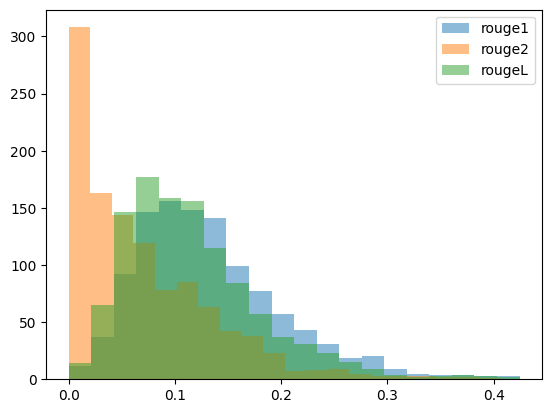

In [21]:
from matplotlib import pyplot as plt
from statistics import mean, median
print(results.keys())
print(mean(results['eval_rouge1']))
print(mean(results['eval_rouge2']))
print(mean(results['eval_rougeL']))
print(median(results['eval_rouge1']))
print(median(results['eval_rouge2']))
print(median(results['eval_rougeL']))

plt.hist(results['eval_rouge1'], bins=20, label='rouge1', alpha=0.5)
plt.hist(results['eval_rouge2'], bins=20, label='rouge2', alpha=0.5)
plt.hist(results['eval_rougeL'], bins=20, label='rougeL', alpha=0.5)
plt.legend()
plt.show()

In [22]:
import torch
sample = preprocessed.test()[0]
source_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
print("_________________SOURCE___________________")
print(source_text)


target_text = tokenizer.decode(sample['labels'], skip_special_tokens=True)
print("__________________TARGET____________________")
print(target_text)


inputs = {k: torch.tensor([v]).to(trainer.model.device)
          for k, v in sample.items() if k == "input_ids"}

generated_ids = trainer.model.generate(
    inputs["input_ids"],
    max_length=MAX_TARGET_LENGTH,
    num_beams=4,
)

pred_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("__________________PREDICTED____________________")
print(pred_text)

_________________SOURCE___________________
endoscopic submucosal dissection ( esd ) is an effective procedure that allows the en bloc resection of premalignant lesions and early gastric cancer ( egc ) in the stomach.1 - 3 however , esd is technically difficult and time consuming.4,5 major complications of esd are bleeding and perforation and its complication rate is higher than that of conventional endoscopic mucosal resection.6 - 8 gastric variceal bleeding is associated with more massive bleeding than esophageal variceal bleeding.9 a fundal varix is closely related to an increased risk of bleeding.9 endoscopic variceal obturation ( evo ) using n - butyl-2-cyanoacrylate ( histoacryl ) is effective for the treatment of gastric varices bleeding.10 - 12 this is , to our knowledge , the first report of the successful treatment of egc adjacent to a fundal varix by esd and evo using cyanoacrylate . a 52-year - old male was referred to our tertiary center for the treatment of egc . his liver

In [45]:
import json
with open('results.json', 'w') as f:
  json.dump(results, f, indent=4)

with open('comparison_text.txt', 'w') as f:
  f.write(f'Source: {source_text}\n')
  f.write(f'Target: {target_text}\n')
  f.write(f'Predicted: {pred_text}\n')

trainer.save_model('trained_model')
tokenizer.save_pretrained('trained_model')

('trained_model/tokenizer_config.json',
 'trained_model/special_tokens_map.json',
 'trained_model/vocab.json',
 'trained_model/merges.txt',
 'trained_model/added_tokens.json',
 'trained_model/tokenizer.json')

In [46]:
!cp -r trained_model drive/MyDrive/

In [47]:
!cp -r results.json drive/MyDrive/
!cp -r comparison_text.txt drive/MyDrive/
!cp -r output drive/MyDrive/
!cp -r logs drive/MyDrive/

cp: cannot stat 'logs': No such file or directory


[{'loss': 1.3291, 'grad_norm': 1.4126254320144653, 'learning_rate': 4.459312839059674e-05, 'epoch': 0.5426181324892607, 'step': 300}, {'eval_loss': 1.277811884880066, 'eval_rouge1': [0.07518796992481203, 0.0558659217877095, 0.13333333333333333, 0.0670391061452514, 0.13846153846153844, 0.16541353383458643, 0.020618556701030927, 0.12903225806451613, 0.09150326797385622, 0.13461538461538464, 0.15384615384615385, 0.0588235294117647, 0.28125, 0.17391304347826086, 0.07619047619047618, 0.1507537688442211, 0.10714285714285712, 0.017241379310344827, 0.15819209039548024, 0.15625, 0.13913043478260873, 0.0975609756097561, 0.11320754716981131, 0.05128205128205127, 0.1967213114754098, 0.11594202898550726, 0.22033898305084748, 0.08, 0.09836065573770492, 0.049079754601226995, 0.14285714285714282, 0.28571428571428575, 0.06153846153846154, 0.13829787234042554, 0.16766467065868265, 0.16091954022988506, 0.3389830508474576, 0.0975609756097561, 0.050314465408805034, 0.18604651162790697, 0.11483253588516747,

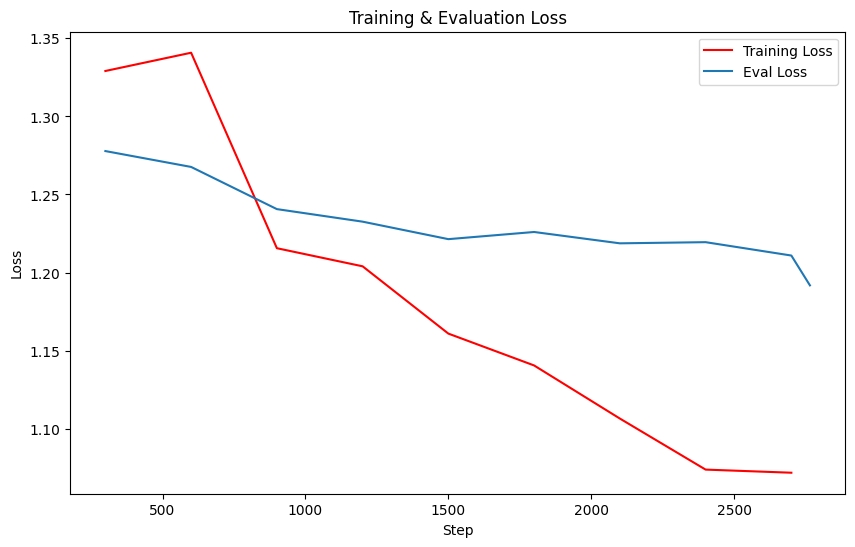

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

# log_history stores training/eval losses
logs = trainer.state.log_history
print(logs)

# convert to DataFrame
df = pd.DataFrame(logs)

# separate train/eval losses
t_loss = df.dropna(subset=["loss"], axis=0)
print(t_loss[["loss", "step"]])
e_loss = df.dropna(subset=["eval_loss"], axis=0)

# plot
plt.figure(figsize=(10,6))
plt.plot(t_loss["step"], t_loss["loss"], 'r-', label="Training Loss")
if "eval_loss" in df:
    plt.plot(e_loss["step"], e_loss["eval_loss"], label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Evaluation Loss")
plt.show()


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
